In [1]:
# 3rd party
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import lightkurve as lk
from collections import defaultdict
import textwrap
import logging

In [2]:
logging.basicConfig(level=logging.INFO,
                    format='%(levelname)s - %(message)s')

logger = logging.getLogger(__name__) 

In [3]:
tce_tbl_fp = Path(
    "/nobackup/jochoa4/work_dir/data/tables/tess_2min_tces_dv_s1-s68_all_msectors_11-29-2023_2157_newlabels_nebs_npcs_bds_ebsntps_to_unks.csv"
)

# -------------------- Load Data --------------------
tce_tbl = pd.read_csv(tce_tbl_fp)
tce_tbl = tce_tbl.rename(columns={"uid": "tce_uid", "label": "disposition"})

if 'target_id' not in tce_tbl.columns:
    logger.debug("target_id not in tce_tbl, adding it")
    tce_tbl['target_id'] = (
        tce_tbl['tce_uid'].astype(str)
               .str.split('-')
               .str[0]
               .astype(int)
    )

/tmp/ipykernel_22763/3144915935.py:6: DtypeWarning: Columns (364,366,367,370,371) have mixed types. Specify dtype option on import or set low_memory=False.
  tce_tbl = pd.read_csv(tce_tbl_fp)


In [6]:

data_tbl_dir = Path("/nobackup/jochoa4/work_dir/data/datasets/TESS_exoplanet_dataset_07-24-2025_no_detrend/tfrecords/")
assert data_tbl_dir.exists(), f"ERROR: data_tbl_dir - {data_tbl_dir} - does not exist."

data_tbl_fp_pattern = "data_tbl*.csv"
data_tbl_fp_gen = data_tbl_dir.glob(data_tbl_fp_pattern)

logger.info(f"Beginning processing data_tbls.")
filtered_dfs = []
for data_tbl_fp in data_tbl_fp_gen:
    df = pd.read_csv(data_tbl_fp)

    # Keep rows with at least one transit or not-transit example
    mask = (df["n_transit_examples"] > 0) | (df["n_not_transit_examples"] > 0)
    filtered = df[mask]

    if not filtered.empty:
        filtered_dfs.append(filtered)

# Concatenate all filtered dataframes
cumulative_df = pd.concat(filtered_dfs, ignore_index=True)

logger.info(f"Cumulative shape: {cumulative_df.shape}")
logger.info(cumulative_df.head())

INFO - Beginning processing data_tbls.
INFO - Cumulative shape: (50549, 59)
INFO -             tce_uid  n_transit_examples  n_not_transit_examples  \
0    62087766-1-S13                 1.0                     1.0   
1  62124646-1-S1-36                 2.0                     1.0   
2  62124646-2-S1-36                 2.0                     2.0   
3  62124646-3-S1-36                 6.0                     6.0   
4    62124646-2-S13                 2.0                     2.0   

                       tfrec_fn  target_id  tce_plnt_num  numberOfPlanets  \
0  raw_shard_1121-8593.tfrecord   62087766             1              1.0   
1  raw_shard_1121-8593.tfrecord   62124646             1              3.0   
2  raw_shard_1121-8593.tfrecord   62124646             2              3.0   
3  raw_shard_1121-8593.tfrecord   62124646             3              3.0   
4  raw_shard_1121-8593.tfrecord   62124646             2              3.0   

   tce_num_transits  tce_num_transits_obs  tce_max_

### Merging columns

In [ ]:
merge_cols = ['tce_uid', 'tce_dikco_msky', 'tce_dikco_msky_err',]
for col in merge_cols:
    if col not in cumulative_df.columns:
        logger.info(f"Column {col} does not exist in cumulative_df")

# cumulative_df = cumulative_df.merge(tce_tbl[merge_cols], how='left', on='tce_uid')

In [ ]:
def _assert_no_nans_in_cols(df, required_cols):
    for col in required_cols:
        if df[col].isna().sum() != 0:
            print(f"NaNs found in column: {col}")

In [ ]:
cumulative_df['tce_dikco_msky']

In [ ]:

# Example threshold: filter EBs with deep transits
def no_eb_3sig_offset(df):
    df = df.copy()

    # Check each for NaNs
    _assert_no_nans_in_cols(df, [ "tce_dikco_msky",  "tce_dikco_msky_err",  "disposition" ])
    
    TESS_PX_SCALE = 21  # arcsec
    KEPLER_PX_SCALE = 3.98  # arcsec
    tess_lower_bound_err = 2.5
    kepler_lower_bound_err = 0.0667
    TESS_TO_KEPLER_PX_SCALE_RATIO = TESS_PX_SCALE / KEPLER_PX_SCALE
    
    df['tce_dikco_msky_original'] = df.apply(lambda r: r['tce_dikco_msky'] * TESS_TO_KEPLER_PX_SCALE_RATIO, axis=1)
    df['tce_dikco_msky_err_original'] = df.apply( lambda r:
        r['tce_dikco_msky_err'] * TESS_TO_KEPLER_PX_SCALE_RATIO
        + tess_lower_bound_err
        - TESS_TO_KEPLER_PX_SCALE_RATIO * kepler_lower_bound_err
        , axis=1
    )
    df['tce_dikco_sigma'] = df.apply(lambda r: r['tce_dikco_msky_original'] / r['tce_dikco_msky_err_original'], axis=1)
    
    condition = ((df['disposition'] == 'EB') & ((df['tce_dikco_sigma'] > 3.0) | (df['tce_dikco_msky_err'] < 0)))
    df.loc[condition, "n_transit_examples"] = 0

    return df

def no_ntp(df):
    df = df.copy()
    _assert_no_nans_in_cols(df, ['disposition'])
    condition = (df['disposition'] != 'NTP')
    df = df.loc[condition]
    return df

In [ ]:
# Summarization function
def summarize_example_counts(df):
    df = df.copy()
    group = df.groupby("disposition")[["n_transit_examples", "n_not_transit_examples"]].sum()
    group["total_examples"] = group["n_transit_examples"] + group["n_not_transit_examples"]
    grand_total = group.sum().to_frame().T
    grand_total.index = ["ALL"]
    return pd.concat([group, grand_total])

# Create a clear text output
def format_summary_text(summary_df):
    lines = []
    for idx, row in summary_df.iterrows():
        line = (
            f"{idx:<8} | "
            f"Transit: {row['n_transit_examples']:>5.0f} | "
            f"Not Transit: {row['n_not_transit_examples']:>5.0f} | "
            f"Total: {row['total_examples']:>5.0f}"
        )
        lines.append(line)
    return "\n".join(lines)

In [ ]:
filter_func_map = {
    "base" : [None],
    "no_eb_3sig" : [no_eb_3sig_offset],
    "no_ntp" : [no_ntp],
    "no_ntp_no_eb_3sig" : [no_ntp, no_eb_3sig_offset]
}

filtered_dfs = {}
summaries = {}
summary_texts = {}

for name, funcs in filter_func_map.items():
    filt_df = cumulative_df.copy()
    for func in funcs:
        if func is not None:
            filt_df = func(filt_df.copy())
    filtered_dfs[name] = filt_df
    summaries[name] = summarize_example_counts(filt_df)
    summary_texts[name] = format_summary_text(summaries[name])

In [ ]:
for name in summaries:
    print(f"--- {name.upper()} ---")
    print(summary_texts[name])
    print()

In [ ]:
n = len(summaries)
cols = 2
rows = (n + 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(12, 5 * rows))

if rows == 1:
    axs = axs.reshape(1, -1)  # ensure 2D

for ax, (name, summary) in zip(axs.flat, summaries.items()):
    summary = summary[:-1]  # remove grand total
    summary[['n_transit_examples', 'n_not_transit_examples']].plot(
        kind='bar', stacked=True, ax=ax, colormap='viridis'
    )
    ax.set_title(f"{name} (absolute)")
    ax.set_ylabel("Examples")
    ax.set_xlabel("Disposition")

plt.tight_layout()


In [ ]:
for (name, summary) in summaries.items():
    
    # Plotting: Absolute and Normalized Bar Charts
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    title_map = {
    "base" : 'No Filter (EB/CP/KP/NEB/NPC/NTP)',
    "no_eb_3sig" : 'Filtered IT EB > 3.0 (EB/CP/KP/NEB/NPC/NTP)',
    "no_ntp" : 'Filtered all NTP (EB/CP/KP/NEB/NPC)',
    "no_ntp_no_eb_3sig" : 'Filtered all NTP & IT EB > 3.0 (EB/CP/KP/NEB/NPC)'
}

    # Absolute count bar chart
     
    summary[:-1][['n_transit_examples', 'n_not_transit_examples']].plot(
        kind='bar', stacked=True, ax=axs[0], colormap='viridis'
    )
    axs[0].set_title(f'Example Counts by Disposition\n{title_map[name]}')
    axs[0].set_ylabel('Number of Examples')
    axs[0].set_xlabel('Disposition')
    axs[0].legend(title='Type')

    # Normalized bar chart
    normalized = summary[:-1][['n_transit_examples', 'n_not_transit_examples']].div(
        summary[:-1]['total_examples'], axis=0
    )
    normalized.plot(kind='bar', stacked=True, ax=axs[1], colormap='viridis')
    axs[1].set_title(f'Normalized Example Distribution\n{title_map[name]} ')
    axs[1].set_ylabel('Fraction of Examples')
    axs[1].set_xlabel('Disposition')
    axs[1].legend(title='Type')

    plt.tight_layout()

# Plotting from Preds

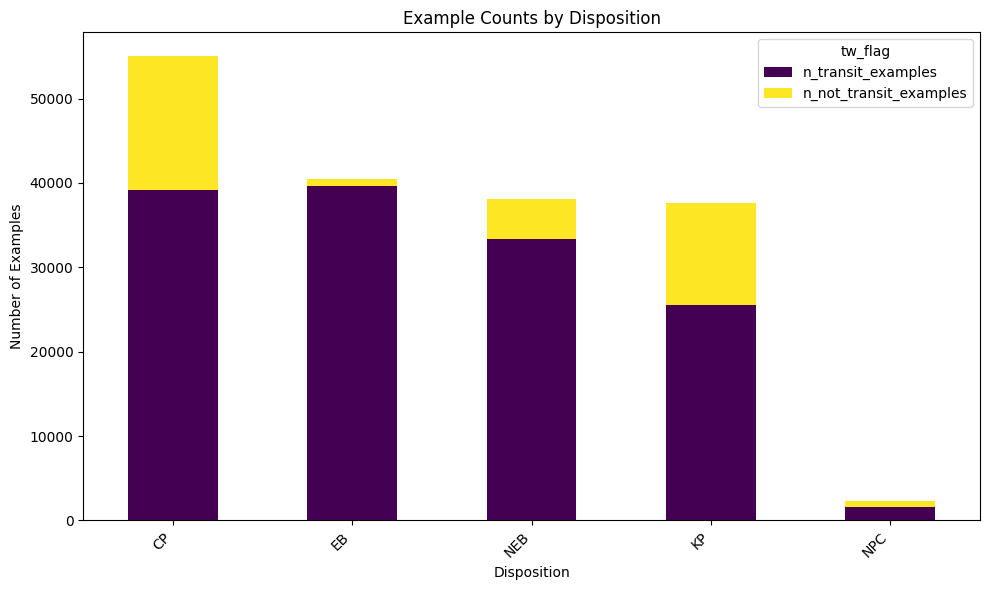

In [4]:
pred_dir = Path("/nobackupp27/jochoa4/work_dir/job_runs/predict_model_TESS_exoplanet_dataset_07-24-2025_no_detrend_split_norm_filt_3sig_it_EB_no_ntp_bal_eb_low_lr/")
split_pred_fps = pred_dir.rglob("*preds_*.csv")

dfs = [pd.read_csv(fp) for fp in split_pred_fps]
df = pd.concat(dfs, ignore_index=True)

# Step 2: Group by disposition and tw_flag
grouped = (
    df.groupby(['disposition', 'tw_flag'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'n_not_transit_examples', 1: 'n_transit_examples'})
)

grouped['total_examples'] = grouped.sum(axis=1)
grouped = grouped.sort_values('total_examples', ascending=False)

# Optional grand total row
grand_total = grouped.sum().to_frame().T
grand_total.index = ["ALL"]
summary_df = pd.concat([grouped, grand_total])

summary_df[:-1][['n_transit_examples', 'n_not_transit_examples']].plot(
    kind='bar', stacked=True, figsize=(10, 6), colormap='viridis'
)
plt.title("Example Counts by Disposition")
plt.ylabel("Number of Examples")
plt.xlabel("Disposition")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()